# Simulation Mise à jour

Ce notebook renferme la simulation permettatn de déterminer la fréqunce de mise à jour du modèle de clustering concernant le projet "Segmentez des clients d'un site e-commerce".

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import plotly.express as px
import time
import warnings
warnings.filterwarnings('ignore')
from datetime import timedelta
from sklearn import cluster, preprocessing
from sklearn.metrics import adjusted_rand_score

### Méthodes du projet

In [2]:
def create_data_for_model(df):
    """ Elabore le dataset d'étude pour l'utilisation de nos modèles """
    last_purchase_date = df["order_purchase_timestamp"].max() + timedelta(days=1)
    aggregation = {
        'order_purchase_timestamp': lambda x: (last_purchase_date - x.max()).days,
        'order_id': 'count',
        'order_value_by_item': ['sum']
    }
    temp_data = df.groupby(['customer_unique_id']).agg(aggregation)
    temp_data.columns = pd.Index([e[0] + "_" + e[1] for e in temp_data.columns.tolist()])
    temp_data.rename(
        columns={'order_purchase_timestamp_<lambda>': 'rfm_recency',
                 'order_id_count': 'rfm_frequency',
                 'order_value_by_item_sum': 'rfm_monetary'}, inplace=True)
    return temp_data

In [3]:
def display_bilan_clusters_all(df, silent=False):
    """ Affiche le tableau comparatif des variables par cluster """
    agg = {}
    for col in df.columns:
        agg[col] = 'mean'
    agg['cluster'] = 'count'
    # on regroupe par customer_unique_id pour appliquer les aggrégations
    clustering_table = df.groupby(["cluster"]).agg(agg)
    # on renomme les colonnes pour l'étude des modèles
    clustering_table.rename(columns={'cluster': 'cluster_size'}, inplace=True)
    clustering_table["cluster_perc"] = round(clustering_table["cluster_size"] / len(df) * 100, 1)
    clustering_table.drop(-1, axis=0, inplace=True, errors='ignore') # pour supprimer la ligne de cluster de bruit du DBSCAN
    if not silent:
        display(clustering_table.head())
    return clustering_table

In [5]:
def compute_period(df):
    """ Identifie les périodes en semaine et en mois dans un df """
    df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
    df["period"] = df['order_purchase_timestamp'].dt.strftime('%Y-%m')
    df["week_period"] = df['order_purchase_timestamp'].dt.strftime('%Y-%V')
    df = df.sort_values(by="week_period")
    return df

## Chargement des données

In [6]:
data = pd.read_csv("simu_dataset.csv", encoding='utf-8', sep='\t', index_col=0)

In [7]:
data.head()

,customer_id,customer_unique_id,order_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,efficient_delivery_elapse,review_score,order_item_id,product_id,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,order_value_by_item
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-25 10:35:35,2017-06-05,10.558623,4,1,a9516a079e37a9c9c36b9b78b10169e8,22.4982,3.9384,office_furniture,41.0,1141.0,1.0,26.4366
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-28 00:09:50,2017-12-19,20.993171,1,2,a9516a079e37a9c9c36b9b78b10169e8,20.3382,4.4820,office_furniture,41.0,1141.0,1.0,49.6404
2,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:26,2017-05-26 09:54:04,2017-06-12,16.587454,3,1,a9516a079e37a9c9c36b9b78b10169e8,22.4982,2.8116,office_furniture,41.0,1141.0,1.0,25.3098
3,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:40,2018-02-28 21:09:00,2018-03-22,21.118750,4,1,a9516a079e37a9c9c36b9b78b10169e8,19.2582,5.5062,office_furniture,41.0,1141.0,1.0,24.7644
4,fd3a0b1bd209f0e7d420c9c3d1127613,567ab47ca4deb92d46dbf54dce07d0a7,574fe1739f65af76badd0999db300b4f,delivered,2017-03-23 15:10:17,2017-04-11 10:16:56,2017-04-24,12.571574,4,1,a9516a079e37a9c9c36b9b78b10169e8,22.8582,2.7108,office_furniture,41.0,1141.0,1.0,25.5690


## Filtre par période

On identifie chaque ligne selon la période de l'année.

In [8]:
periodic_data = compute_period(data)

In [9]:
periodic_data.head()

,customer_id,customer_unique_id,order_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,efficient_delivery_elapse,review_score,order_item_id,product_id,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,order_value_by_item,period,week_period
20475,08c5351a6aca1c1589a38f244edeee9d,b7d76e111c89f7ebf14761390f0f7d17,2e7a8482f6fb09756ca50c10d7bfc047,shipped,2016-09-04 21:15:19,2016-10-20 00:00:00,2016-10-20,0.000000,1,1,c1488892604e4ba5cff5b4eb4d595400,7.1982,5.7006,furniture_decor,59.0,426.0,2.0,12.8988,2016-09,2016-35
99097,08c5351a6aca1c1589a38f244edeee9d,b7d76e111c89f7ebf14761390f0f7d17,2e7a8482f6fb09756ca50c10d7bfc047,shipped,2016-09-04 21:15:19,2016-10-20 00:00:00,2016-10-20,0.000000,1,2,f293394c72c9b5fafd7023301fc21fc2,5.9220,5.7006,furniture_decor,41.0,754.0,3.0,23.2452,2016-09,2016-35
95413,683c54fc24d40ee9f8a6fc179fd9856c,4854e9b3feff728c13ee5fc7d1547e92,e5fa5a7210941f7d56d0208e4e071d35,canceled,2016-09-05 00:15:34,2016-10-28 00:00:00,2016-10-28,0.000000,1,1,f3c2d01a84c947b078e32bbef0718962,10.7100,2.8008,telephony,42.0,381.0,1.0,13.5108,2016-09,2016-36
70360,86dc2ffce2dfff336de2f386a786e574,830d5b7aaa3b6f1e9ad63703bec97d23,bfbd0f9bdef84302105ad712db648a6c,delivered,2016-09-15 12:16:38,2016-11-09 07:47:38,2016-10-04,-36.324745,1,3,5a6b04657a4c5ee34285d1e4619a96b4,8.0982,0.5094,health_beauty,34.0,1036.0,1.0,25.8228,2016-09,2016-37
100376,b106b360fe2ef8849fbbd056f777b4d5,0eb1ee9dba87f5b36b4613a65074337c,71303d7e93b399f5bcd537d124c0bcfa,canceled,2016-10-02 22:07:52,2016-10-25 00:00:00,2016-10-25,0.000000,1,1,d2998d7ced12f83f9b832f33cf6507b6,18.0000,1.6812,baby,32.0,561.0,1.0,19.6812,2016-10,2016-39


## Weekly

In [10]:
print("Les périodes vont de", periodic_data["week_period"].min(), "à", periodic_data["week_period"].max())

Les périodes vont de 2016-35 à 2018-36


In [31]:
list_period = periodic_data["week_period"].unique()
# list_period = periodic_data["period"].unique()
list_period

array(['2016-35', '2016-36', '2016-37', '2016-39', '2016-40', '2016-41',
       '2016-51', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05',
       '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11',
       '2017-12', '2017-13', '2017-14', '2017-15', '2017-16', '2017-17',
       '2017-18', '2017-19', '2017-20', '2017-21', '2017-22', '2017-23',
       '2017-24', '2017-25', '2017-26', '2017-27', '2017-28', '2017-29',
       '2017-30', '2017-31', '2017-32', '2017-33', '2017-34', '2017-35',
       '2017-36', '2017-37', '2017-38', '2017-39', '2017-40', '2017-41',
       '2017-42', '2017-43', '2017-44', '2017-45', '2017-46', '2017-47',
       '2017-48', '2017-49', '2017-50', '2017-51', '2017-52', '2018-01',
       '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07',
       '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2018-13',
       '2018-14', '2018-15', '2018-16', '2018-17', '2018-18', '2018-19',
       '2018-20', '2018-21', '2018-22', '2018-23', 

In [13]:
from sklearn.metrics import adjusted_rand_score

In [33]:
old = False
result = []
print("Il y a", len(list_period), "périodes à parcourir.")
for index, period in enumerate(list_period):
    print("Période:", period)
    data_period = periodic_data.loc[periodic_data["week_period"] <= period, :]
    
    if len(data_period) < 4:
        continue
    data_period_model = create_data_for_model(data_period)
    X = data_period_model.values
    scaler = preprocessing.RobustScaler()
    X_norm = scaler.fit_transform(X)
    kmeans = cluster.KMeans(n_clusters=3, random_state=42)
    kmeans.fit(X_norm)
    
    if old:
        pred = ref_kmeans.predict(X_norm)
        ari_score = round(adjusted_rand_score(pred, kmeans.labels_), 4)
        # print("ARI-Score", ari_score)
        if index % 5 == 0:
            print("Traitement en cours. Index :", index)
        # if ari_score < 0.5:
        #     print("Nouvelle référence :", period, ", à l'index :", index)
        #     ref_kmeans = kmeans  
        result.append({
                'week_period': period,
                'ari_score': ari_score
            })
    else:
        old = True
        ref_kmeans = kmeans
        print("Référence période :", period)

Il y a 95 périodes à parcourir.
Période: 2016-35
Période: 2016-36
Période: 2016-37
Référence période : 2016-37
Période: 2016-39
Période: 2016-40
Période: 2016-41
Traitement en cours. Index : 5
Période: 2016-51
Période: 2017-01
Période: 2017-02
Période: 2017-03
Période: 2017-04
Traitement en cours. Index : 10
Période: 2017-05
Période: 2017-06
Période: 2017-07
Période: 2017-08
Période: 2017-09
Traitement en cours. Index : 15
Période: 2017-10
Période: 2017-11
Période: 2017-12
Période: 2017-13
Période: 2017-14
Traitement en cours. Index : 20
Période: 2017-15
Période: 2017-16
Période: 2017-17
Période: 2017-18
Période: 2017-19
Traitement en cours. Index : 25
Période: 2017-20
Période: 2017-21
Période: 2017-22
Période: 2017-23
Période: 2017-24
Traitement en cours. Index : 30
Période: 2017-25
Période: 2017-26
Période: 2017-27
Période: 2017-28
Période: 2017-29
Traitement en cours. Index : 35
Période: 2017-30
Période: 2017-31
Période: 2017-32
Période: 2017-33
Période: 2017-34
Traitement en cours.

In [38]:
df_result = pd.DataFrame(result)
df_result.head()

,week_period,ari_score
0,2016-39,-0.2000
1,2016-40,0.3631
2,2016-41,0.3568
3,2016-51,0.2275
4,2017-01,0.5425


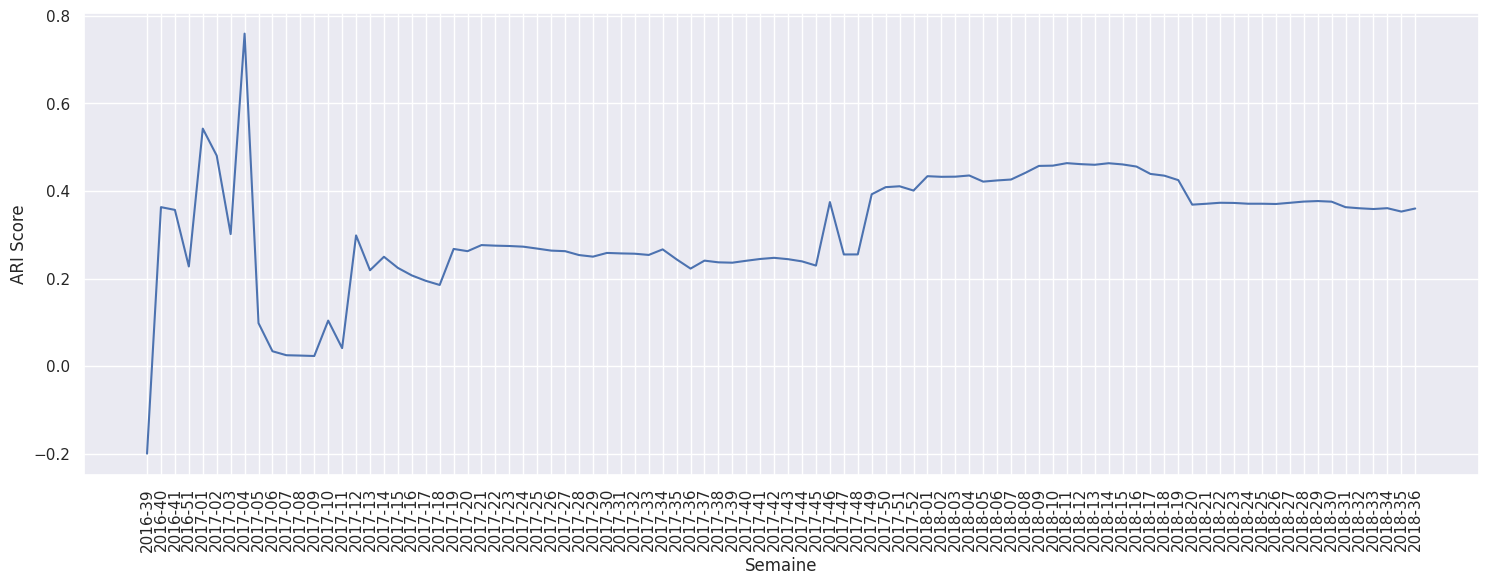

In [39]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.lineplot(df_result, x='week_period', y='ari_score')
plt.xlabel("Semaine")
plt.ylabel("ARI Score")
ax.tick_params(axis='x', labelrotation=90)